In [2]:
# !pip install mlquantify

import os
import numpy as np
import pandas as pd
import pdb
import statistics

### Quantifiers

In [3]:
def CC(test, thr=0.5):
    result = np.sum(test >= thr) / len(test)
    result = max(0, min(result, 1))

    return np.array([result, 1 - result], dtype=float)

def ACC(test, TprFpr, thr=0.5):
    dC = CC(test)  # Implement CC function separately

    tpr_fpr_row = TprFpr[TprFpr[:, 0] == thr, 1:3].astype(float)
    if tpr_fpr_row.size == 0:
        raise ValueError("Threshold value not found in TprFpr.")

    tpr, fpr = tpr_fpr_row[0]

    result = (dC[0] - fpr) / (tpr - fpr) if (tpr - fpr) != 0 else 0
    result = max(0, min(result, 1))

    return np.array([result, 1 - result], dtype=float)


def DyS(p_score, n_score, test, measure="topsoe", bins=np.arange(2, 22, 2), err=1e-5):
    results = []

    for b_size in bins:
        Sty_1 = getHist(p_score, b_size)  # Implement getHist separately
        Sty_2 = getHist(n_score, b_size)
        Uy = getHist(test, b_size)

        def f(x):
            return DySyn_distance(np.vstack([(Sty_1 * x) + (Sty_2 * (1 - x)), Uy]), method=measure)  # Implement DyS_distance separately

        best_alpha = TernarySearch(0, 1, f, err)  # Implement TernarySearch separately
        results.append(best_alpha)

    result = statistics.median(results)
    result = max(0, min(result, 1))

    return np.array([result, 1 - result])

In [ ]:
def DySyn(ts, measure):
    MF = np.arange(0.1, 1.0, 0.2) # mudar de 0.2 a 0.7
    results = []
    distances = []

    for mf in MF:
        scores = MoSS(1000, 0.5, mf)  # Implement MoSS function separately
        test_p = scores[scores[:, 2] == 1, 0]
        test_n = scores[scores[:, 2] == 2, 0]

        if measure == "sord":
            rQnt = DySyn_SORD(test_p, test_n, ts)  # Implement DySyn_SORD separately
        else:
            rQnt = DySyn_DyS(test_p, test_n, ts, measure)  # Implement DySyn_DyS separately

        distances.append(rQnt[1])
        results.append(rQnt[0][0])

    best_result = round(results[np.argmin(distances)], 2)
    return [np.array([best_result, 1 - best_result]), min(distances)]

def DySyn_DyS(p_score, n_score, test, measure="hellinger", b_sizes = list(range(2, 21, 2)) + [30]):
    results = []
    vDistAll = []

    for b_size in b_sizes:
        Sty_1 = getHist(p_score, b_size)  # Implement getHist separately
        Sty_2 = getHist(n_score, b_size)
        Uy = getHist(test, b_size)

        def f(x):
            return DySyn_distance(np.vstack([(Sty_1 * x) + (Sty_2 * (1 - x)), Uy]), method=measure)  # Implement DySyn_distance separately

        best_alpha = TernarySearch(0, 1, f, 1e-2)  # Implement TernarySearch separately
        results.append(best_alpha)
        vDistAll.append(f(best_alpha))

    median_result = np.median(results)
    return [np.array([round(median_result, 2), 1 - round(median_result, 2)]), min(vDistAll)]

def PNTDiff(pos, neg, test, pos_prop):
    p_w = pos_prop / len(pos)
    n_w = (1 - pos_prop) / len(neg)
    t_w = -1 / len(test)

    p = np.column_stack((pos, np.full(len(pos), p_w)))
    n = np.column_stack((neg, np.full(len(neg), n_w)))
    t = np.column_stack((test, np.full(len(test), t_w)))

    v = np.vstack((p, n, t))
    v = v[v[:, 0].argsort()]

    acc = v[0, 1]
    total_cost = 0

    for i in range(1, len(v)):
        cost_mul = v[i, 0] - v[i - 1, 0]
        total_cost += abs(cost_mul * acc)
        acc += v[i, 1]

    return total_cost

def DySyn_SORD(p_score, n_score, test):
    def f(x):
        return PNTDiff(p_score, n_score, test, x)

    best_alpha = TernarySearch(0, 1, f, 1e-5)  # Implement TernarySearch separately
    vDist = f(best_alpha)

    return [np.array([round(best_alpha, 2), 1 - round(best_alpha, 2)]), vDist]

### Utils

In [5]:
def getTPRandFPRbyThreshold(validation_scores):
    unique_scores = np.arange(0.01, 1.00, 0.01)
    arrayOfTPRandFPRByTr = []

    total_positive = np.sum(validation_scores[:, 2] == 1)
    total_negative = np.sum(validation_scores[:, 2] == 2)

    for threshold in unique_scores:
        fp = np.sum((validation_scores[:, 0] > threshold) & (validation_scores[:, 2] == 2))
        tp = np.sum((validation_scores[:, 0] > threshold) & (validation_scores[:, 2] == 1))
        tpr = tp / total_positive if total_positive > 0 else 0
        fpr = fp / total_negative if total_negative > 0 else 0

        arrayOfTPRandFPRByTr.append([round(threshold, 2), tpr, fpr])

    return np.array(arrayOfTPRandFPRByTr, dtype=object)

In [6]:
import numpy as np

def DySyn_distance(x, method="hellinger"):
    if method == "ord":
        x_dif = x[0, :] - x[1, :]
        acum = 0
        aux = 0
        for val in x_dif:
            aux += val
            acum += aux
        return abs(acum)

    if method == "topsoe":
        return sum(x[0, i] * np.log((2 * x[0, i]) / (x[0, i] + x[1, i])) +
                   x[1, i] * np.log((2 * x[1, i]) / (x[1, i] + x[0, i])) for i in range(x.shape[1]))

    if method == "jensen_difference":
        return sum(((x[0, i] * np.log(x[0, i]) + x[1, i] * np.log(x[1, i])) / 2) -
                   ((x[0, i] + x[1, i]) / 2) * np.log((x[0, i] + x[1, i]) / 2) for i in range(x.shape[1]))

    if method == "taneja":
        return sum(((x[0, i] + x[1, i]) / 2) * np.log((x[0, i] + x[1, i]) / (2 * np.sqrt(x[0, i] * x[1, i])))
                   for i in range(x.shape[1]))

    if method == "hellinger":
        return 2 * np.sqrt(1 - sum(np.sqrt(x[0, i] * x[1, i]) for i in range(x.shape[1])))

    if method == "prob_symm":
        return 2 * sum(((x[0, i] - x[1, i]) ** 2) / (x[0, i] + x[1, i]) for i in range(x.shape[1]))

    raise ValueError("measure argument must be a valid option")

def getHist(scores, nbins):
    breaks = np.linspace(0, 1, nbins + 1)
    breaks[-1] = 1.1
    re = np.full(len(breaks) - 1, 1 / (len(breaks) - 1))

    for i in range(1, len(breaks)):
        re[i - 1] = (re[i - 1] + np.sum((scores >= breaks[i - 1]) & (scores < breaks[i]))) / (len(scores) + 1)

    return re

def TernarySearch(left, right, f, eps=1e-4):
    while True:
        if abs(left - right) < eps:
            return (left + right) / 2

        leftThird = left + (right - left) / 3
        rightThird = right - (right - left) / 3

        if f(leftThird) > f(rightThird):
            left = leftThird
        else:
            right = rightThird


In [7]:
def MoSS(n, alpha, m):
    p_score = np.random.uniform(size=int(n * alpha)) ** m
    n_score = 1 - (np.random.uniform(size=int(round(n * (1 - alpha), 0))) ** m)
    scores = np.column_stack((np.concatenate((p_score, n_score)), np.concatenate((p_score, n_score)), np.concatenate((np.ones(len(p_score)), np.full(len(n_score), 2)))))
    # pdb.set_trace()
    return scores

In [8]:
scrs = MoSS(2, 0.5, 0.0)
scrs

array([[1., 1., 1.],
       [0., 0., 2.]])

In [9]:
def apply_qntMethod(qntMethod, p_score, n_score, test, TprFpr=None, thr=None, measure="hellinger"):
    import mlquantify  # Ensure the mlquantify package is available
    
    if qntMethod == "CC":
        return CC(test=test, thr=thr)

    if qntMethod == "ACCSyn":
        return ACCSyn(ts=test, measure=measure)

    if qntMethod == "XSyn":
        return XSyn(ts=test, measure=measure)

    if qntMethod == "MAXSyn":
        return MAXSyn(ts=test, measure=measure)

    if qntMethod == "T50Syn":
        return T50Syn(ts=test, measure=measure)

    if qntMethod == "MSSyn":
        return MSSyn(ts=test, measure=measure)

    if qntMethod == "MS2Syn":
        return MS2Syn(ts=test, measure=measure)

    if qntMethod == "SMMSyn":
        return SMMSyn(ts=test, measure=measure)

    if qntMethod == "PCC":
        return mlquantify.PCC(test)

    if qntMethod == "ACC":
        return ACC(test=test, TprFpr=TprFpr, thr=thr)

    if qntMethod == "T50":
        return T50(ts=test, TprFpr=TprFpr)

    if qntMethod == "X":
        return X(ts=test, TprFpr=TprFpr)

    if qntMethod == "MAX":
        return MAX(ts=test, TprFpr=TprFpr)

    if qntMethod == "PACC":
        return mlquantify.methods.PACC(ts=test, TprFpr=TprFpr, thr=thr)

    if qntMethod == "DySyn":
        return DySyn(ts=test, measure=measure)

    if qntMethod == "HDy-LP":
        return mlquantify.HDy_LP(p_score=p_score, n_score=n_score, test=test)

    if qntMethod == "DyS":
        return DyS(p_score=p_score, n_score=n_score, test=test, measure=measure)

    if qntMethod == "SORD":
        return mlquantify.SORD(p_score=p_score, n_score=n_score, test=test)

    if qntMethod == "MS":
        return MS(ts=test, TprFpr=TprFpr)

    if qntMethod == "MS2":
        return MS2(ts=test, TprFpr=TprFpr)

    if qntMethod == "SMM":
        return SMM(p_scores=p_score, n_scores=n_score, t_scores=test)

    print("ERROR - Quantification method was not applied!")
    return None

### Proposal

In [10]:
def ACCSyn(ts, measure):
    MF = np.arange(0.05, 1.0, 0.01)
    results = []
    distances = []

    for mf in MF:
        scores = MoSS(500, 0.5, mf)  # Implement MoSS function separately
        test_p = scores[scores[:, 2] == 1, 0]
        test_n = scores[scores[:, 2] == 2, 0]

        rQnt = DySyn_DyS(test_p, test_n, ts, measure, [10])  # Implement DySyn_DyS separately

        distances.append(np.round(rQnt[1],3))

    TprFpr = np.array(getTPRandFPRbyThreshold(MoSS(1000, 0.5, MF[np.argmin(distances)]))).astype(float)  # Implement getTPRandFPRbyThreshold

    dC = CC(ts)  # Implement CC function separately

    tpr_fpr_row = TprFpr[TprFpr[:, 0] == 0.5, 1:3].astype(float)
    if tpr_fpr_row.size == 0:
        raise ValueError("Threshold value not found in TprFpr.")

    tpr, fpr = tpr_fpr_row[0]

    result = (dC[0] - fpr) / (tpr - fpr) if (tpr - fpr) != 0 else 0
    result = max(0, min(result, 1))

    return np.array([result, 1 - result], dtype=float)

In [11]:
def X(ts, TprFpr):
    dC = CC(ts)  # Implement CC function separately

    min_index = abs((1 - TprFpr[:, 1]) - TprFpr[:, 2])
    min_index = np.argmin(min_index)

    tpr_fpr_row = TprFpr[min_index, 1:3].astype(float)
    if tpr_fpr_row.size == 0:
        raise ValueError("Threshold value not found in TprFpr.")

    tpr, fpr = tpr_fpr_row

    result = (dC[0] - fpr) / (tpr - fpr) if (tpr - fpr) != 0 else 0
    result = max(0, min(result, 1))

    return np.array([result, 1 - result], dtype=float)

def XSyn(ts, measure):
    MF = np.arange(0.05, 1.0, 0.01)
    results = []
    distances = []

    # Synthetic scores generation
    for mf in MF:
      scores = MoSS(500, 0.5, mf)  # Implement MoSS function separately
      test_p = scores[scores[:, 2] == 1, 0]
      test_n = scores[scores[:, 2] == 2, 0]

      rQnt = DySyn_DyS(test_p, test_n, ts, measure, [10])  # Implement DySyn_DyS separately

      distances.append(np.round(rQnt[1],3))

    # Generate TPR and FPR by the min distance in MF
    TprFpr = np.array(getTPRandFPRbyThreshold(MoSS(1000, 0.5, MF[np.argmin(distances)]))).astype(float)  # Implement getTPRandFPRbyThreshold
    dC = CC(ts)  # Implement CC function separately

    # Usual X implementation
    min_index = abs((1 - TprFpr[:, 1]) - TprFpr[:, 2])
    min_index = np.argmin(min_index)

    tpr_fpr_row = TprFpr[min_index, 1:3].astype(float)
    # if tpr_fpr_row.size == 0:
    #   raise ValueError("Threshold value not found in TprFpr.")

    tpr, fpr = tpr_fpr_row

    result = (dC[0] - fpr) / (tpr - fpr) if (tpr - fpr) != 0 else 0
    result = max(0, min(result, 1))

    return np.array([result, 1 - result], dtype=float)

In [12]:
def MAX(ts, TprFpr):
    dC = CC(ts)  # Implement CC function separately

    # Usual MAX implementation
    max_index = abs(TprFpr[:, 1] - TprFpr[:, 2])
    max_index = np.argmax(max_index)

    tpr_fpr_row = TprFpr[max_index, 1:3].astype(float)

    tpr, fpr = tpr_fpr_row

    result = (dC[0] - fpr) / (tpr - fpr) if (tpr - fpr) != 0 else 0
    result = max(0, min(result, 1))

    return np.array([result, 1 - result], dtype=float)

def MAXSyn(ts, measure):
    MF = np.arange(0.05, 1.0, 0.01)
    results = []
    distances = []

    # Synthetic scores generation
    for mf in MF:
      scores = MoSS(500, 0.5, mf)  # Implement MoSS function separately
      test_p = scores[scores[:, 2] == 1, 0]
      test_n = scores[scores[:, 2] == 2, 0]

      rQnt = DySyn_DyS(test_p, test_n, ts, measure, [10])  # Implement DySyn_DyS separately

      distances.append(np.round(rQnt[1],3))

    # Generate TPR and FPR by the min distance in MF
    TprFpr = np.array(getTPRandFPRbyThreshold(MoSS(1000, 0.5, MF[np.argmin(distances)]))).astype(float)  # Implement getTPRandFPRbyThreshold
    dC = CC(ts)  # Implement CC function separately

    # Usual MAX implementation
    max_index = abs(TprFpr[:, 1] - TprFpr[:, 2])
    max_index = np.argmax(max_index)

    tpr_fpr_row = TprFpr[max_index, 1:3].astype(float)

    tpr, fpr = tpr_fpr_row

    result = (dC[0] - fpr) / (tpr - fpr) if (tpr - fpr) != 0 else 0
    result = max(0, min(result, 1))

    return np.array([result, 1 - result], dtype=float)

In [13]:
def T50(ts, TprFpr):
    dC = CC(ts)  # Implement CC function separately

    # Usual T50 implementation
    min_index = abs(TprFpr[:, 1] - 0.5)
    min_index = np.argmin(min_index)

    tpr_fpr_row = TprFpr[min_index, 1:3].astype(float)

    tpr, fpr = tpr_fpr_row

    result = (dC[0] - fpr) / (tpr - fpr) if (tpr - fpr) != 0 else 0
    result = max(0, min(result, 1))

    return np.array([result, 1 - result], dtype=float)

def T50Syn(ts, measure):
    MF = np.arange(0.05, 1.0, 0.01)
    results = []
    distances = []

    # Synthetic scores generation
    for mf in MF:
      scores = MoSS(500, 0.5, mf)  # Implement MoSS function separately
      test_p = scores[scores[:, 2] == 1, 0]
      test_n = scores[scores[:, 2] == 2, 0]

      rQnt = DySyn_DyS(test_p, test_n, ts, measure, [10])  # Implement DySyn_DyS separately

      distances.append(np.round(rQnt[1],3))

    # Generate TPR and FPR by the min distance in MF
    TprFpr = np.array(getTPRandFPRbyThreshold(MoSS(1000, 0.5, MF[np.argmin(distances)]))).astype(float)  # Implement getTPRandFPRbyThreshold
    dC = CC(ts)  # Implement CC function separately

    # Usual T50 implementation
    min_index = abs(TprFpr[:, 1] - 0.5)
    min_index = np.argmin(min_index)

    tpr_fpr_row = TprFpr[min_index, 1:3].astype(float)

    tpr, fpr = tpr_fpr_row

    result = (dC[0] - fpr) / (tpr - fpr) if (tpr - fpr) != 0 else 0
    result = max(0, min(result, 1))

    return np.array([result, 1 - result], dtype=float)

ValueError: Could not interpret value `col2` for `hue`. An entry with this name does not appear in `data`.

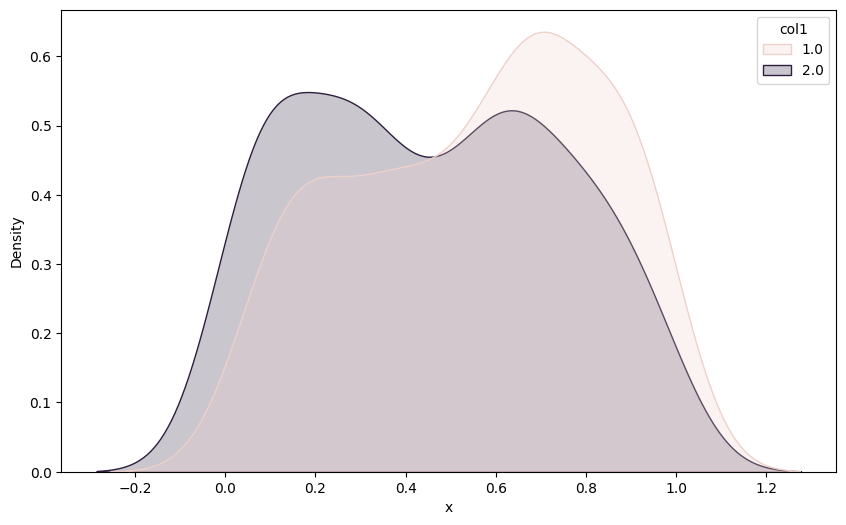

In [29]:
x=MoSS(500, 0.5, 0.8)
x = pd.DataFrame(x)
x.columns = ['x', 'y', 'col1']
x

# prompt: plot density graph using KDE in x variable, create different color for each value in 3 column

import seaborn as sns
import matplotlib.pyplot as plt

# Assuming your dataframe is named 'df' and the columns are 'x', 'col1', 'col2', 'col3'
# Replace 'df' with your actual dataframe name and column names if different

# Create the density plot
plt.figure(figsize=(10, 6))
sns.kdeplot(data=x, x='x', hue='col1', fill=True)
sns.kdeplot(data=x, x='x', hue='col2', fill=True)
sns.kdeplot(data=x, x='x', hue='col3', fill=True)

plt.title('Density Plot of x with different colors for columns')
plt.xlabel('x')
plt.ylabel('Density')
plt.show()


In [ ]:
def MS(ts, TprFpr):
  results = []
  dC = CC(ts)  # Implement CC function separately

  # Usual MS implementation
  threshold_set = np.arange(0.01, 1.00, 0.01)

  for threshold in threshold_set:
    threshold = round(threshold, 2) # 0.060000003 shenanigans
    tpr, fpr = TprFpr[TprFpr[:, 0] == threshold, 1:3].astype(float)[0]

    result = (dC[0] - fpr) / (tpr - fpr) if (tpr - fpr) != 0 else 0
    result = max(0, min(result, 1))

    results.append(result)

    result = np.median(results)
  return np.array([result, 1 - result], dtype=float)

def MS2(ts, TprFpr):
    results = []

    dC = CC(ts)  # Implement CC function separately

    # Usual MS2 implementation
    index = np.where(abs(TprFpr[:,1]-TprFpr[:,2]) > (1/4))[0].tolist()
    threshold_set = TprFpr[index,0]
    if threshold_set.shape[0] == 0:
      threshold_set = np.arange(0.01, 1.00, 0.01)

    # else usual MS
    for threshold in threshold_set:
      threshold = round(threshold, 2) # 0.060000003 shenanigans
      tpr, fpr = TprFpr[TprFpr[:, 0] == threshold, 1:3].astype(float)[0]

      result = (dC[0] - fpr) / (tpr - fpr) if (tpr - fpr) != 0 else 0
      result = max(0, min(result, 1))

      results.append(result)

    result = np.median(results)
    return np.array([result, 1 - result], dtype=float)

In [ ]:
def MSSyn(ts, measure):
    MF = np.arange(0.05, 1.0, 0.01)
    results = []
    distances = []

    # Synthetic scores generation
    for mf in MF:
      scores = MoSS(500, 0.5, mf)  # Implement MoSS function separately
      test_p = scores[scores[:, 2] == 1, 0]
      test_n = scores[scores[:, 2] == 2, 0]

      rQnt = DySyn_DyS(test_p, test_n, ts, measure, [10])  # Implement DySyn_DyS separately

      distances.append(np.round(rQnt[1],3))

    # Generate TPR and FPR by the min distance in MF
    TprFpr = np.array(getTPRandFPRbyThreshold(MoSS(1000, 0.5, MF[np.argmin(distances)]))).astype(float)  # Implement getTPRandFPRbyThreshold
    dC = CC(ts)  # Implement CC function separately

    # Usual MS implementation
    threshold_set = np.arange(0.01, 1.00, 0.01)

    for threshold in threshold_set:
      threshold = round(threshold, 2) # 0.060000003 shenanigans
      tpr, fpr = TprFpr[TprFpr[:, 0] == threshold, 1:3].astype(float)[0]

      result = (dC[0] - fpr) / (tpr - fpr) if (tpr - fpr) != 0 else 0
      result = max(0, min(result, 1))

      results.append(result)

    result = np.median(results)
    return np.array([result, 1 - result], dtype=float)

In [ ]:
def MS2Syn(ts, measure):
    MF = np.arange(0.05, 1.0, 0.01)
    results = []
    distances = []

    # Synthetic scores generation
    for mf in MF:
      scores = MoSS(500, 0.5, mf)  # Implement MoSS function separately
      test_p = scores[scores[:, 2] == 1, 0]
      test_n = scores[scores[:, 2] == 2, 0]

      rQnt = DySyn_DyS(test_p, test_n, ts, measure, [10])  # Implement DySyn_DyS separately

      distances.append(np.round(rQnt[1],3))

    # Generate TPR and FPR by the min distance in MF
    TprFpr = np.array(getTPRandFPRbyThreshold(MoSS(1000, 0.5, MF[np.argmin(distances)]))).astype(float)  # Implement getTPRandFPRbyThreshold
    dC = CC(ts)  # Implement CC function separately

    # Usual MS2 implementation
    index = np.where(abs(TprFpr[:,1]-TprFpr[:,2]) > (1/4))[0].tolist()
    threshold_set = TprFpr[index,0]
    if threshold_set.shape[0] == 0:
      threshold_set = np.arange(0.01, 1.00, 0.01)

    # else usual MS
    for threshold in threshold_set:
      threshold = round(threshold, 2) # 0.060000003 shenanigans
      tpr, fpr = TprFpr[TprFpr[:, 0] == threshold, 1:3].astype(float)[0]

      result = (dC[0] - fpr) / (tpr - fpr) if (tpr - fpr) != 0 else 0
      result = max(0, min(result, 1))

      results.append(result)

    result = np.median(results)
    return np.array([result, 1 - result], dtype=float)

In [ ]:
def SMM(p_scores, n_scores, t_scores):
  mean_p_scores = np.mean(p_scores)
  mean_n_scores = np.mean(n_scores)
  mean_t_scores = np.mean(t_scores)

  alpha = (mean_t_scores - mean_n_scores) / (mean_p_scores - mean_n_scores)
  alpha = max(0, min(alpha, 1))

  return np.round([alpha, abs(1-alpha)], 2)

In [ ]:
def SMMSyn(ts, measure):
    MF = np.arange(0.05, 1.0, 0.01)
    distances = [] # distances generated from DySyn

    # Synthetic scores generation
    for mf in MF:
      scores = MoSS(500, 0.5, mf)  # Implement MoSS function separately
      test_p = scores[scores[:, 2] == 1, 0]
      test_n = scores[scores[:, 2] == 2, 0]

      rQnt = DySyn_DyS(test_p, test_n, ts, measure, [10])
      distances.append(np.round(rQnt[1],3))

    # pdb.set_trace()
    best_scores = MoSS(1000, 0.5, MF[np.argmin(distances)]) # sempre NaN em 0 de distances
    best_p = best_scores[best_scores[:, 2] == 1, 0]
    best_n = best_scores[best_scores[:, 2] == 2, 0]
    result = SMM(best_p, best_n, ts)

    return result

## Main

In [ ]:
def exec_eval_complexity(MFtr):

    vdist = {"TS": "topsoe", "JD": "jensen_difference", "PS": "prob_symm", "ORD": "ord", "SORD": "sord", "TN": "taneja", "HD": "hellinger"}

    var_perc = np.arange(0, 1.05, 0.05)  # class distribution
    var_size = [500]  # test set size
    n_tests = 3  # replication
    MF = np.arange(0.05, 1.00, 0.1)  # m parameter for MoSS model
    MF = np.round(MF, 2) # 0.1500000003 shenanigans

    # PC RAFAEL
    # qnt = ['ACCSyn-TS',
    #        'XSyn-TS',
    #        'MAXSyn-TS',
    #        'T50Syn-TS',
    #        'MS2Syn-TS',
    #        'SMMSyn-TS',
    #        'DySyn-TS']

    # PC LUIZ
    qnt = ['T50', 'MS', 'MS2', 'SMM', 'DyS-TS', 'X', 'MAX', 'ACC', 'CC']

    results = []

    for mi in range(len(MFtr)):
        scores = MoSS(1000, 0.5, MFtr[mi])  # Implement MoSS function
        # pdb.set_trace()
        TprFpr = np.array(getTPRandFPRbyThreshold(scores)).astype(float)  # Implement getTPRandFPRbyThreshold

        for k in range(len(var_size)):
            for i in range(len(var_perc)):
                # print(f"Class distr. {var_perc[i]}")
                for j in range(n_tests):
                    for ti in range(len(MF)):
                        for qi in qnt:

                            pdb.set_trace()

                            test_set = MoSS(var_size[k], var_perc[i], MF[ti])
                            freq_REAL = pd.Series(test_set[:, 2]).value_counts(normalize=True).reindex([1, 2], fill_value=0)
                            qntMethod = qi.split("-")[0] if "-" in qi else qi

                            if qntMethod != "HDy-LP":
                                try:
                                    nk = int(qntMethod.split("_")[0])
                                except ValueError:
                                    nk = 1
                                qntMethod = "DySyn" if nk != 1 else qntMethod

                            measure = None
                            if len(qi.split("-")) > 1:
                                measure = vdist.get(qi.split("-")[1])

                            # pdb.set_trace()
                            qnt_re = apply_qntMethod(
                                qntMethod=qntMethod,
                                p_score=scores[scores[:, 2] == 1, 0],
                                n_score=scores[scores[:, 2] == 2, 0],
                                test=test_set[:, 0],
                                TprFpr=TprFpr,
                                thr=0.5,
                                measure=measure
                            )  # Implement apply_qntMethod

                            freq_PRE = np.round(qnt_re[0],3)

                            results.append([
                                MFtr[mi],
                                MF[ti],
                                freq_REAL.get(1, 0),
                                freq_PRE,
                                np.round(abs(freq_REAL.get(1, 0) - freq_PRE), 2),
                                measure,
                                qnt_re[1],
                                qi
                            ])


    results_df = pd.DataFrame(results, columns=["MFtr", "MFte", "R_1", "P_1", "AE", "Distance", "Value.dist", "Qnt"]) # Before AE was MAE, keep in mind!

    return results_df

: 

## RUN

In [ ]:
if __name__ == "__main__":
    m_Tr = np.arange(0.05, 1.00, 0.1)
    # m_Tr = [0.7]
    m_Tr = np.round(m_Tr, 2)
    
    print("############ - It will take a couple of minutes! - ############")
    result = pd.DataFrame()

    # re = exec_eval_complexity([0.7])
    for i in m_Tr:
        print(f"Running for MF {i}")
        re = exec_eval_complexity([i])
        result = pd.concat([result, re])
        result.to_csv("results.csv", index=False)

grouped = result.groupby(['Qnt', 'MFte', 'MFtr']).agg({'MAE': 'mean'}).reset_index()

## Results

In [ ]:
grouped = result.groupby(['Qnt', 'MFte', 'MFtr']).agg({'MAE': 'mean'}).reset_index()

In [ ]:
import plotly.graph_objects as go
import ipywidgets as widgets
from IPython.display import display, clear_output


mftr_dropdown = widgets.Dropdown(
    options=grouped['MFtr'].unique(),
    description='MFtr:'
)

mftr_dropdown.value = grouped['MFtr'].unique()[0]

def update_plot(change):
    selected_mftr = mftr_dropdown.value
    filtered_data = grouped[grouped['MFtr'] == selected_mftr]

    fig = go.Figure()
    for qnt_val in filtered_data['Qnt'].unique():
        qnt_data = filtered_data[filtered_data['Qnt'] == qnt_val]
        fig.add_trace(go.Scatter(x=qnt_data['MFte'], y=qnt_data['MAE'], mode='lines+markers', name=qnt_val))

    fig.update_layout(title=f'MAE vs MFte for MFtr = {selected_mftr}',
                      xaxis_title='MFte',
                      yaxis_title='MAE')

    clear_output(wait=True)
    display(fig)
    display(mftr_dropdown)



mftr_dropdown.observe(update_plot, names='value')
display(mftr_dropdown)
update_plot(None)

Dropdown(description='MFtr:', options=(np.float64(0.7),), value=np.float64(0.7))